In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import gym
import math

In [2]:
import numpy as np
import random

In [3]:
from collections import deque
class ReplayBuffer(object):
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def push(self, state, action, reward, next_state, done):
        state = np.expand_dims(state, 0)
        next_state = np.expand_dims(next_state, 0)

        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        state, action, reward, next_state, done = zip(*random.sample(self.buffer, batch_size))
        return np.concatenate(state), action, reward, np.concatenate(next_state), done    
    def __len__(self):
        return len(self.buffer)

In [4]:
epsilon_start = 1.0
epsilon_final = 0.01
epsilon_decay = 500

epsilon_by_frame = lambda frame_idx: epsilon_final + (epsilon_start - epsilon_final) * math.exp(-1. * frame_idx / epsilon_decay)

In [5]:
env_id = "CartPole-v0"
env = gym.make(env_id)

In [6]:
env.observation_space.shape

(4,)

In [19]:
class DQN(nn.Module):
    def __init__(self, input_shape, n_actions):
        super(DQN, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_shape, 128),
            nn.LeakyReLU(0.2),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, n_actions)
        )
    
    def forward(self, x):
        return self.layers(x)
    
    def act(self, state, epsilon):
        if random.random() > epsilon:
            state = torch.FloatTensor(state).unsqueeze(0)
            q_value = self.forward(state)
            action = q_value.max(1)[1].item()
        else:
            action = random.randrange(env.action_space.n)
        return action

In [40]:
current_model = DQN(env.observation_space.shape[0], env.action_space.n)
target_model = DQN(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(current_model.parameters())

In [41]:
replay_buffer = ReplayBuffer(5000)

In [42]:
def update_target(current_model, target_model):
    target_model.load_state_dict(current_model.state_dict())

In [43]:
update_target(current_model, target_model)

In [44]:
def compute_td_loss(batch_size):
    state, action, reward, next_state, done = replay_buffer.sample(batch_size)

    state = torch.FloatTensor(state)
    next_state = torch.FloatTensor(next_state)
    action = torch.LongTensor(action)
    reward = torch.FloatTensor(reward)
    done = torch.FloatTensor(done)

    q_values = current_model(state)
    next_q_values = current_model(next_state)
    next_q_state_values = target_model(next_state)

    q_values = q_values.gather(1, action.unsqueeze(1)).squeeze(1)
    next_q_value = next_q_state_values.gather(1, torch.max(next_q_values, 1)[1].unsqueeze(1)).squeeze(1)
    expected_q_value = reward + gamma * next_q_value * (1 - done)

    loss = (q_values - expected_q_value.detach()).pow(2).mean()

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    return loss

In [45]:
num_frames = 15000
batch_size = 128
gamma = 0.99

losses = []
all_rewards = []
episode_reward = 0

In [46]:
state = env.reset()
for frame_idx in range(1, num_frames + 1):
    epsilon = epsilon_by_frame(frame_idx=frame_idx)
    action = current_model.act(state, epsilon)

    next_state, reward, done, _ = env.step(action)
    replay_buffer.push(state, action, reward, next_state, done)

    state = next_state
    episode_reward += reward

    if done:
        state = env.reset()
        all_rewards.append(episode_reward)
        episode_reward = 0
    
    if len(replay_buffer) > batch_size:
        loss = compute_td_loss(batch_size)
        losses.append(loss.item())
    
    if frame_idx % 500 == 0:
        print("Frame: {}\tLoss: {}".format(frame_idx, np.mean(losses)))
        losses = []
    
    if frame_idx % 200 == 0:
        update_target(current_model, target_model)

Frame: 500	Loss: 0.09314131258200774
Frame: 1000	Loss: 0.13818474042415618
Frame: 1500	Loss: 0.1727644565552473
Frame: 2000	Loss: 0.21940499960258603
Frame: 2500	Loss: 0.3480830874964595
Frame: 3000	Loss: 0.40996030754595997
Frame: 3500	Loss: 0.5679965360090137
Frame: 4000	Loss: 0.8775221168026328
Frame: 4500	Loss: 1.125402379527688
Frame: 5000	Loss: 1.3155395743772387
Frame: 5500	Loss: 1.6858313155546785
Frame: 6000	Loss: 1.7980146683901548
Frame: 6500	Loss: 2.579252507857978
Frame: 7000	Loss: 2.6015693252757193
Frame: 7500	Loss: 3.269518120110035
Frame: 8000	Loss: 3.5559419419616463
Frame: 8500	Loss: 3.19076793525368
Frame: 9000	Loss: 3.2889902133494617
Frame: 9500	Loss: 4.067613758593797
Frame: 10000	Loss: 3.8784093187004327
Frame: 10500	Loss: 3.7896085571199656
Frame: 11000	Loss: 4.155431427270174
Frame: 11500	Loss: 4.0782695101946596
Frame: 12000	Loss: 4.567742372393608
Frame: 12500	Loss: 4.114049258112908
Frame: 13000	Loss: 4.516885664835573
Frame: 13500	Loss: 4.2377185513824225


In [47]:
import matplotlib.pyplot as plt

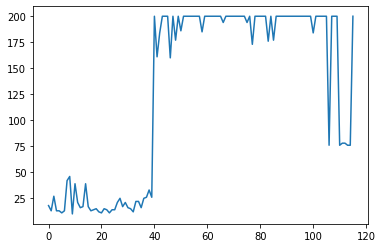

In [48]:
plt.plot(all_rewards)

In [59]:
env._max_episode_steps = 1000 # Play game for longer

In [61]:
done = False
cnt = 0
env.reset()
observation = env.reset()
while not done:
    cnt += 1
    action = current_model.act(observation, epsilon=0.0)
    observation, reward, done, _ = env.step(action)
    env.render()
    if done:
        break

env.close()
print(f"{cnt}/{env._max_episode_steps} moves")

1000/1000 moves
